# PART 2: Feature Selection / Engineering & Regression Modeling

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd 
df=pd.read_csv('/content/gdrive/MyDrive/clean_imdb_2.csv')

In [3]:
import numpy as np

In [ ]:
df.head()

,Unnamed: 0,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,first_genre,year
0,0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",CCH Pounder,Avatar,886204,4834,Wes Studi,"['avatar', 'future', 'marine', 'native', 'para...",http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237.0,2009,936.0,7.9,33000,Action,2009.0
1,1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309.0,"['Action', 'Adventure', 'Fantasy']",Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,"['goddess', 'marriage ceremony', 'marriage pro...",http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300.0,2007,5000.0,7.1,0,Action,2007.0
2,2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200.0,"['Action', 'Adventure', 'Thriller']",Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,"['bomb', 'espionage', 'sequel', 'spy', 'terror...",http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245.0,2015,393.0,6.8,85000,Action,2015.0
3,3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448.0,"['Action', 'Thriller']",Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,"['deception', 'imprisonment', 'lawlessness', '...",http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250.0,2012,23000.0,8.5,164000,Action,2012.0
4,4,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73.0,"['Action', 'Adventure', 'Sci-Fi']",Daryl Sabara,John Carter,212204,1873,Polly Walker,"['alien', 'american civil war', 'male nipple',...",http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,English,USA,PG-13,263.0,2012,632.0,6.6,24000,Action,2012.0


In [15]:
df = df.drop("Unnamed: 0", axis = 1)

In [ ]:
df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,first_genre,year
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",CCH Pounder,Avatar,886204,4834,Wes Studi,"['avatar', 'future', 'marine', 'native', 'para...",http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237.0,2009,936.0,7.9,33000,Action,2009.0
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309.0,"['Action', 'Adventure', 'Fantasy']",Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,"['goddess', 'marriage ceremony', 'marriage pro...",http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300.0,2007,5000.0,7.1,0,Action,2007.0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200.0,"['Action', 'Adventure', 'Thriller']",Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,"['bomb', 'espionage', 'sequel', 'spy', 'terror...",http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245.0,2015,393.0,6.8,85000,Action,2015.0
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448.0,"['Action', 'Thriller']",Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,"['deception', 'imprisonment', 'lawlessness', '...",http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250.0,2012,23000.0,8.5,164000,Action,2012.0
4,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73.0,"['Action', 'Adventure', 'Sci-Fi']",Daryl Sabara,John Carter,212204,1873,Polly Walker,"['alien', 'american civil war', 'male nipple',...",http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,English,USA,PG-13,263.0,2012,632.0,6.6,24000,Action,2012.0


## 2.1: Feature Selection

In [16]:
df1 = df.copy()

In [17]:
# make movie_title an index of df1
df1 = df1.set_index("movie_title")

In [18]:
# separate Y label
Y = df1["imdb_score"]

### 2.1.1: Feature Selection deep dive

In [19]:
# features need to be removed 
remove = ["director_name", "actor_1_name", "actor_2_name", "actor_3_name", "genres", 
          "cast_total_facebook_likes", "language", "country", "imdb_score", "title_year", "plot_keywords", "movie_imdb_link"]

In [20]:
# the remaining dataframe (note: not all left are predictive features yet)
df1 = df1.drop(remove, axis = 1)

Why do we remove these features?

* names: We assume their facebook likes can directly associate with the popularity / importance of each director / actor. Facebook might not be everyone's primary choice of following / liking directors or actors these days, but it is a good relative scale of measurement for their importance. This also avoids us creating too many bag of words vectors, if not neccessary.

* genres: I want to discuss various genres in unsupervised clustering, in a different notebook, so for this regression mission, we'll inherit previous assumption about the first genre being the "strongest associated genre" with a movie, and only use that feature instead.

* cast total facebook likes: it is equal to the sum of actor 1, actor 2, and actor 3 facebook likes. It'll be highly correlated to these features and most likely be rated least important from the models. So we'll just toss it now.

* language: all movies in this dataset are in english, no need to keep this info

* country: Because we removed all the non-Eng movies, my assumption is that as long as the movie is in English, people don't care much about whether the movie was American, British, or else. For example, when we compare the Harry Pottery series with, say, Mary Poppins', do we really rate the movie higher depends on the country of origin? To me, it's not important.

* imdb_score: this is our predicting target

In [21]:
# have to do dummie variables here because 
# when I first splitted the train / test set, there are different numbers of  categories 
# in content_rating, in the train and test set
# causing modeling unable to fit because of mismatched dataframe shapes

df1 = pd.get_dummies(df1, columns=['content_rating', 'first_genre'], sparse = True)

In [22]:
X = df1.copy()

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4603 entries, Avatar  to My Date with Drew 
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   num_critic_for_reviews    4603 non-null   float64         
 1   duration                  4603 non-null   float64         
 2   director_facebook_likes   4603 non-null   float64         
 3   actor_3_facebook_likes    4603 non-null   float64         
 4   actor_1_facebook_likes    4603 non-null   float64         
 5   gross                     4603 non-null   float64         
 6   num_voted_users           4603 non-null   int64           
 7   num_user_for_reviews      4603 non-null   float64         
 8   budget                    4603 non-null   float64         
 9   actor_2_facebook_likes    4603 non-null   float64         
 10  movie_facebook_likes      4603 non-null   int64           
 11  year                      4603 non-null  

### 2.1.2: Train-validation-test split

In [ ]:
X1 = X.copy()
Y1 = Y.copy()

In [ ]:
X1.head(1)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,num_user_for_reviews,budget,actor_2_facebook_likes,movie_facebook_likes,year,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-PG,content_rating_Unrated,content_rating_X,first_genre_Action,first_genre_Adventure,first_genre_Animation,first_genre_Biography,first_genre_Comedy,first_genre_Crime,first_genre_Documentary,first_genre_Drama,first_genre_Family,first_genre_Fantasy,first_genre_Horror,first_genre_Musical,first_genre_Mystery,first_genre_Romance,first_genre_Sci-Fi,first_genre_Thriller,first_genre_Western
movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Avatar,723.0,178.0,0.0,855.0,1000.0,760.0,886204,3054.0,237.0,936.0,33000,2009.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X1, Y1, test_size=0.20, shuffle=True)

In [ ]:
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 3682 observation with 44 features
test data has 921 observation with 44 features


## 2.2: Feature Engineering 


In [ ]:
# X_test.shape

In [ ]:
X_train = X_train.fillna('', inplace=False)

In [ ]:
X_test = X_test.fillna('', inplace=False)

In [ ]:
# X_train.info()

In [ ]:
X_train.head(1)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,num_user_for_reviews,budget,actor_2_facebook_likes,movie_facebook_likes,year,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-PG,content_rating_Unrated,content_rating_X,first_genre_Action,first_genre_Adventure,first_genre_Animation,first_genre_Biography,first_genre_Comedy,first_genre_Crime,first_genre_Documentary,first_genre_Drama,first_genre_Family,first_genre_Fantasy,first_genre_Horror,first_genre_Musical,first_genre_Mystery,first_genre_Romance,first_genre_Sci-Fi,first_genre_Thriller,first_genre_Western
movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The Wizard of Oz,213.0,102.0,149.0,357.0,695.0,22.0,291875,533.0,2.0,421.0,14000,1939.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test.head(1)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,num_user_for_reviews,budget,actor_2_facebook_likes,movie_facebook_likes,year,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-PG,content_rating_Unrated,content_rating_X,first_genre_Action,first_genre_Adventure,first_genre_Animation,first_genre_Biography,first_genre_Comedy,first_genre_Crime,first_genre_Documentary,first_genre_Drama,first_genre_Family,first_genre_Fantasy,first_genre_Horror,first_genre_Musical,first_genre_Mystery,first_genre_Romance,first_genre_Sci-Fi,first_genre_Thriller,first_genre_Western
movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The Shallows,186.0,86.0,174.0,2.0,619.0,54.0,12983,139.0,17.0,350.0,0,2016.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## 2.3: Model Selection

### 2.3.0: Summary Model Performance based on MSE (of fitting the entire dataset)

* Best: Random Forest (0.0798)
* Next best: Gradient Boosting (0.308)
* Okay: KNN (0.768)
* Worst (very bad): SGD (6.29)


### 2.3.1: KNN prediction

#### 2.3.1 - 0: Feature Normalization

In [35]:
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

#### 2.3.1 - 1: Base Model, K = 5

In [ ]:
model = KNeighborsRegressor(n_neighbors=5, metric = 'euclidean')
print(model)

model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
pred_y = model.predict(X_test)

score=model.score(X_test,y_test)
print(score)

mse = mean_squared_error(y_test, pred_y)
print("Mean Squared Error:",mse)

0.2090375513095487
Mean Squared Error: 1.0746440825190011


#### 2.3.1 - 2: Grid Search CV

In [38]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [ ]:
# hyper tuning K
parameters = {
    'n_neighbors':[1,3,5,7,9]
}
Grid_KNN = GridSearchCV(KNeighborsRegressor(metric = 'euclidean'),parameters, cv=5, refit = True)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='euclidean',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.19808765952194243
Best parameters set:
n_neighbors:9


In [ ]:
# save the best Knn model from gridsearch
best_KNN_model = Grid_KNN.best_estimator_

#### 2.3.1 - 3: Validation on test set

In [ ]:
best_KNN_model.fit(X_test, y_test)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

In [ ]:
pred_y_test = best_KNN_model.predict(X_test)

score=best_KNN_model.score(X_test,y_test)
print(score)

mse = mean_squared_error(y_test, pred_y_test)
print("Mean Squared Error:",mse)

0.37079140158368207
Mean Squared Error: 0.8548766102331068


#### 2.3.1 - 4: Model Performance on Entire Dataset

In [ ]:
best_KNN_model.fit(X1, Y1)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

In [ ]:
pred_y_all = best_KNN_model.predict(X1)

score=best_KNN_model.score(X1, Y1)
print(score)

mse = mean_squared_error(Y1, pred_y_all)
print("Mean Squared Error:",mse)

0.3786777408024073
Mean Squared Error: 0.767583111390049


In [ ]:
test_title = X1[X1.index.str.match("Titanic")]

In [ ]:
# single prediction for "Titantic"
best_KNN_model.predict(test_title)

array([8.37777778])

In [ ]:
# actual titanic score
row_titanic = df.loc[df["movie_title"].str.match( "Titanic")]

In [ ]:
row_titanic.imdb_score

25    7.7
Name: imdb_score, dtype: float64

In [ ]:
# single prediction for The Lord of the Rings: The Fellowship of the Ring
LoR = X1[X1.index.str.match("The Lord of the Rings: The Fellowship of the Ring")]

In [ ]:
best_KNN_model.predict(LoR)

array([8.81111111])

In [ ]:
# actual LoR score
row_LoR = df.loc[df["movie_title"].str.match( "The Lord of the Rings: The Fellowship of the Ring")]
row_LoR.imdb_score

264    8.8
Name: imdb_score, dtype: float64

### 2.3.2: SGD Regressor

#### 2.3.2 - 1 : Base Model

In [ ]:
from sklearn.linear_model import SGDRegressor
clf = SGDRegressor(max_iter=1000, tol=1e-3, random_state= 42)
clf.fit(X_train, y_train)
y_pred_sgd = clf.predict(X_test)

In [ ]:
print ('Mean squared error: \n', mean_squared_error (y_test, y_pred_sgd))

Mean squared error: 
 5.350491667481222e+38


#### 2.3.2 - 2: Grid Search CV

In [ ]:
param_grid = {
    'alpha': [0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'max_iter': [1000, 2000, 3000]
}
GRID_SGD = GridSearchCV(clf, param_grid, refit = True)
GRID_SGD.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=42, shuffle=True,
                                    tol=0.001, validation_fraction=0.1,
                                    verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'max_iter': [1000, 2000, 3000]},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [ ]:
print_grid_search_metrics(GRID_SGD)

Best score: -2.785298996915254e+30
Best parameters set:
alpha:100
learning_rate:optimal
max_iter:1000


In [ ]:
best_SGD_model = GRID_SGD.best_estimator_

#### 2.3.2 - 3: Validate on test set

In [ ]:
best_SGD_model.fit(X_test, y_test)

SGDRegressor(alpha=100, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='optimal', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
pred_y_test_sgd = best_SGD_model.predict(X_test)

score=best_SGD_model.score(X_test,y_test)
print(score)

mse = mean_squared_error(y_test, pred_y_test_sgd)
print("Mean Squared Error:",mse)

-2.63728182150746e+31
Mean Squared Error: 3.5831527882394894e+31


#### 2.3.2 - 4: Model Performance on the entire dataset

In [ ]:
best_SGD_model.fit(X1, Y1)

SGDRegressor(alpha=100, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='optimal', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
pred_y_test_sgd_all = best_SGD_model.predict(X1)

score=best_SGD_model.score(X1, Y1)
print(score)

mse = mean_squared_error(Y1, pred_y_test_sgd_all)
print("Mean Squared Error:",mse)

-5.091460220773798e+29
Mean Squared Error: 6.290003005569706e+29


SGD did horribly...

### 2.3.3: Random Forest Regressor

In [23]:
# because RF overcomes the issue of scaling and normalization, we will use the df before normalization
X2 = X.copy()
Y2 = Y.copy()

In [24]:
X2.shape

(4603, 44)

In [25]:
Y2.shape

(4603,)

In [26]:
X2.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,num_user_for_reviews,budget,actor_2_facebook_likes,movie_facebook_likes,year,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-PG,content_rating_Unrated,content_rating_X,first_genre_Action,first_genre_Adventure,first_genre_Animation,first_genre_Biography,first_genre_Comedy,first_genre_Crime,first_genre_Documentary,first_genre_Drama,first_genre_Family,first_genre_Fantasy,first_genre_Horror,first_genre_Musical,first_genre_Mystery,first_genre_Romance,first_genre_Sci-Fi,first_genre_Thriller,first_genre_Western
movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Avatar,723.0,178.0,0.0,855.0,1000.0,760.0,886204,3054.0,237.0,936.0,33000,2009.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Pirates of the Caribbean: At World's End,302.0,169.0,563.0,1000.0,40000.0,309.0,471220,1238.0,300.0,5000.0,0,2007.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Spectre,602.0,148.0,0.0,161.0,11000.0,200.0,275868,994.0,245.0,393.0,85000,2015.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
The Dark Knight Rises,813.0,164.0,22000.0,23000.0,27000.0,448.0,1144337,2701.0,250.0,23000.0,164000,2012.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
John Carter,462.0,132.0,475.0,530.0,640.0,73.0,212204,738.0,263.0,632.0,24000,2012.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
from sklearn import model_selection
X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(X2, Y2, test_size=0.20, shuffle=True, random_state=42)

In [28]:
print('training data has ' + str(X1_train.shape[0]) + ' observation with ' + str(X1_train.shape[1]) + ' features')
print('test data has ' + str(X1_test.shape[0]) + ' observation with ' + str(X1_test.shape[1]) + ' features')

training data has 3682 observation with 44 features
test data has 921 observation with 44 features


In [29]:
X1_train = X1_train.fillna('', inplace=False)
X1_test = X1_test.fillna('', inplace=False)

In [30]:
from sklearn.ensemble import RandomForestRegressor

#### 2.3.3 - 1: Base Model

In [31]:
RF_regressor = RandomForestRegressor(random_state = 42)

In [33]:
RF_regressor.fit(X1_train, y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [36]:
base_RF_pred_y = RF_regressor.predict(X1_test)

score=RF_regressor.score(X1_test,y1_test)
print(score)

mse = mean_squared_error(y1_test, base_RF_pred_y)
print("Mean Squared Error:",mse)

0.5198268043465617
Mean Squared Error: 0.5731125939196527


#### 2.3.3 - 2: Grid Search CV

In [39]:
parameters = {
    'n_estimators' : [60, 80, 100, 120, 140],
    'max_features': ["auto", "sqrt", "log2"]
}
Grid_RF = GridSearchCV(RF_regressor, parameters, cv=5, refit = True)
Grid_RF.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [40]:
print_grid_search_metrics(Grid_RF)

Best score: 0.5134058647370467
Best parameters set:
max_features:auto
n_estimators:140


In [41]:
best_RF_model = Grid_RF.best_estimator_

#### 2.3.3 - 3: Validation on test set

In [42]:
best_RF_model.fit(X1_test, y1_test)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [43]:
pred_y_test_rf = best_RF_model.predict(X1_test)

score=best_RF_model.score(X1_test,y1_test)
print(score)

mse = mean_squared_error(y1_test, pred_y_test_rf)
print("Mean Squared Error:",mse)

0.9220988427331143
Mean Squared Error: 0.09297923064991469


#### 2.3.3 - 4: Model Performance on the entire dataset

In [44]:
best_RF_model.fit(X2,Y2)
pred_y_rf_all = best_RF_model.predict(X2)

score=best_RF_model.score(X2,Y2)
print(score)

mse = mean_squared_error(Y2, pred_y_rf_all)
print("Mean Squared Error:",mse)

0.9354247043691606
Mean Squared Error: 0.0797764857213796


#### 2.3.3 - 5: Feature Importance

In [46]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [54]:
plt.rcParams.update({'figure.figsize': (15, 12)})
plt.rcParams.update({'font.size': 14})

Text(0.5, 0, 'Random Forest Feature Importance')

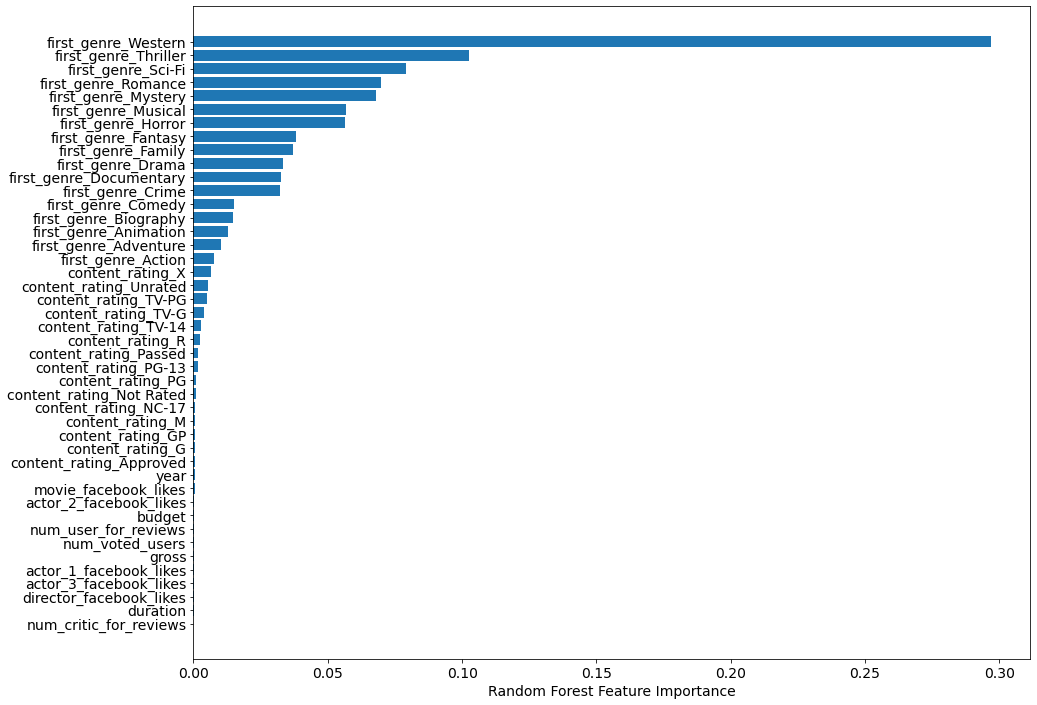

In [56]:
# 1) RF built-in importance
sorted_idx = best_RF_model.feature_importances_.argsort()
plt.barh(X2.columns, best_RF_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [58]:
# 2) Permutation basesd importance
perm_importance = permutation_importance(best_RF_model, X2, Y2)

Text(0.5, 0, 'Random Forest Feature Importance')

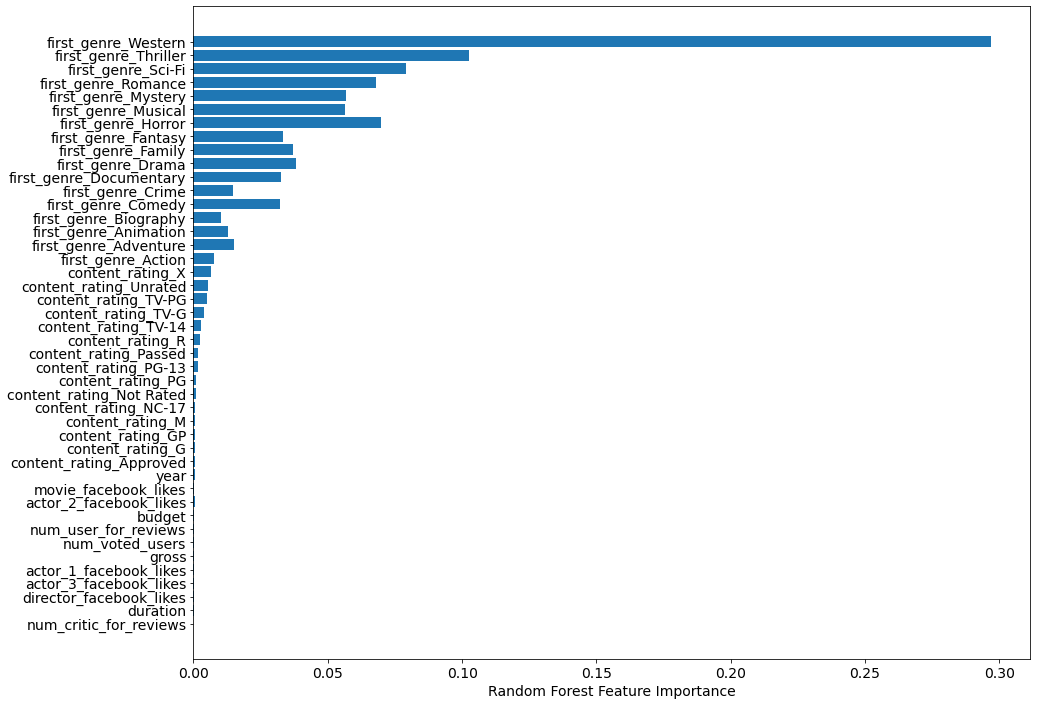

In [59]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X2.columns, best_RF_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### 2.3.4: Gradient Boosting Regressor

we can use the same X and Y train / test dataframes from Random Forest

#### 2.3.4 - 1: Base Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
base_GBR = GradientBoostingRegressor(random_state=42)

In [ ]:
base_GBR.fit(X1_train, y1_train)
base_GBR_pred_y = base_GBR.predict(X1_test)

score=base_GBR.score(X1_test,y1_test)
print(score)

mse = mean_squared_error(y1_test, base_GBR_pred_y)
print("Mean Squared Error:",mse)

0.49666344765894305
Mean Squared Error: 0.6007593088035642


#### 2.3.4 - 2: Grid Search CV

In [ ]:
parameters = {
    'learning_rate': [0.05, 0.1, 0.25, 0.5],
    'n_estimators' : [60, 80, 100, 120, 140],
    'max_features': ["auto", "sqrt", "log2"]
}
Grid_GBR = GridSearchCV(base_GBR, parameters, cv=5, refit = True)
Grid_GBR.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...e,
                          

In [ ]:
print_grid_search_metrics(Grid_GBR)

Best score: 0.5251711024075416
Best parameters set:
learning_rate:0.25
max_features:auto
n_estimators:140


In [ ]:
best_GBR_model = Grid_GBR.best_estimator_

#### 2.3.4 - 3: Validation on test set

In [ ]:
best_GBR_model.fit(X1_test, y1_test)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.25, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=140,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
pred_y_test_gbr = best_GBR_model.predict(X1_test)

score=best_GBR_model.score(X1_test,y1_test)
print(score)

mse = mean_squared_error(y1_test, pred_y_test_gbr)
print("Mean Squared Error:",mse)

0.9247441691323127
Mean Squared Error: 0.0898218909896998


#### 2.4.4 - 4: Model Peformance on the entire dataset

In [ ]:
best_GBR_model.fit(X2,Y2)

pred_y__gbr_all = best_GBR_model.predict(X2)

score=best_GBR_model.score(X2,Y2)
print(score)

mse = mean_squared_error(Y2, pred_y__gbr_all)
print("Mean Squared Error:",mse)

0.7506000450775129
Mean Squared Error: 0.3081093434945819
